In [56]:
import pickle
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
file_path = "Statistical_Analysis/statistical_analysis.pkl"
with open(file_path, 'rb') as f:
    data = pickle.load(f)

In [57]:
dataset = data["dataset"]

In [58]:
user_codes, users = pd.factorize(dataset["user-id"])
item_codes, items = pd.factorize(dataset["item-id"])
n_users, n_items = len(users), len(items)

dataset["user_code"] = user_codes
dataset["item_code"] = item_codes

data_sorted = dataset.sort_values(by=["user_code", "item_code"])

sorted_users = data_sorted["user_code"].values
sorted_items = data_sorted["item_code"].values

data_manual = np.ones(len(data_sorted), dtype=int)
indices_manual = sorted_items  

counts = np.bincount(sorted_users, minlength=n_users)

indptr_manual = np.zeros(n_users + 1, dtype=int)
indptr_manual[1:] = np.cumsum(counts)

R = csr_matrix(
    (data_manual, indices_manual, indptr_manual), 
    shape=(n_users, n_items)
)

print("Sparse Matrix Shape:", R.shape)

Sparse Matrix Shape: (100000, 9999)


In [59]:

item_popularity = np.array(R.sum(axis=0)).flatten()

user_shared_mass = R.dot(item_popularity)

user_rating_counts = np.array(R.sum(axis=1)).flatten()

total_co_ratings = user_shared_mass - user_rating_counts

divisor = max(1, n_users - 1)
avg_common_items = total_co_ratings / divisor

stats_df = pd.DataFrame({
    "user_id": users,            
    "user_idx": range(n_users),  
    "rating_count": user_rating_counts,
    "avg_common": avg_common_items
})

print(stats_df[["user_id", "rating_count", "avg_common"]].head())
stats_df.to_csv("Section3_Part2_stats.csv")

                user_id  rating_count  avg_common
0  A0040548BPHKXMHH3NTI            12    0.070711
1  A0045750NMY09KVSTE01             7    0.023300
2  A0070287EH1P1FHWO3GW            10    0.059821
3  A0149220O8WD7KG3O5XR            18    0.046510
4  A0160612BLIWRHROHLLE             7    0.024490


In [61]:
if not sp.isspmatrix_csr(R):
    R = R.tocsr()
    
n_users = R.shape[0]
global_max_val = -1
global_max_coords = (-1, -1)
global_min_nonzero = np.inf

for start_idx in range(0, n_users, 10000):
    end_idx = min(start_idx + 10000, n_users)

    R_batch = R[start_idx:end_idx]
    batch_intersection = R_batch.dot(R.T)
    
    for i in range(end_idx - start_idx):
        batch_intersection[i, start_idx + i] = 0
    batch_intersection.eliminate_zeros()
    if batch_intersection.nnz > 0:
        batch_max = batch_intersection.data.max()
        if batch_max > global_max_val:
            global_max_val = batch_max
            
            linear_idx = batch_intersection.argmax()
            local_r, c = np.unravel_index(linear_idx, batch_intersection.shape)
            global_max_coords = (start_idx + local_r, c)
            
        batch_min = batch_intersection.data.min()
        if batch_min < global_min_nonzero:
            global_min_nonzero = batch_min

    sys.stdout.flush()
    del batch_intersection, R_batch

print(f"Maximum number of common items: {global_max_val}")
print(f"Between User {global_max_coords[0]} and User {global_max_coords[1]} indcies")
print(f"Minimum (non-zero) common items: {global_min_nonzero}")

Maximum number of common items: 514
Between User 24605 and User 96318 indcies
Minimum (non-zero) common items: 1


In [62]:
n_users = R.shape[0]
user_features = np.zeros((n_users, 3), dtype=np.float32)

if not sp.isspmatrix_csr(R):
    R = R.tocsr()

for start_idx in range(0, n_users, 10000):
    end_idx = min(start_idx + 10000, n_users)
    
    R_batch = R[start_idx:end_idx]
    batch_intersection = R_batch.dot(R.T)
    
    for i in range(end_idx - start_idx):
        global_col = start_idx + i
        batch_intersection[i, global_col] = 0
    batch_intersection.eliminate_zeros()
    
    for i in range(batch_intersection.shape[0]):
        row = batch_intersection.getrow(i)
        
        if row.nnz > 0:
            avg_val = row.data.mean()
            max_val = row.data.max()
            min_val = row.data.min()
            
            user_features[start_idx + i] = [avg_val, max_val, min_val]
        else:
            user_features[start_idx + i] = [0.0, 0.0, 0.0]
    sys.stdout.flush()

print(f"Feature Matrix Shape: {user_features.shape}")
print("\nSample of the feature value vectors")
print("Organized in the following Average Common, Max Common, Min Common")
print(user_features[:5])

Feature Matrix Shape: (100000, 3)

Sample of the feature value vectors
Organized in the following Average Common, Max Common, Min Common
[[1.1629934 5.        1.       ]
 [1.2091334 3.        1.       ]
 [1.1057302 6.        1.       ]
 [1.3711674 7.        1.       ]
 [1.0268344 3.        1.       ]]


In [68]:
summ_UF = 0
count = 0
for user_feature in user_features:
    summ_UF += user_feature
    count += 1
mu = summ_UF / count

sum_squared_diff_UF = 0
for user_feature in user_features:
    diff = user_feature - mu
    sum_squared_diff_UF += diff ** 2
sigma = np.sqrt(sum_squared_diff_UF / count)
sigma[sigma == 0] = 1e-8
normalized_features = (user_features - mu) / sigma

new_mean = np.mean(normalized_features, axis=0)
new_std = np.std(normalized_features, axis=0)

print("\n Sample of normalized vetor")
print(normalized_features[0:5])


 Sample of normalized vetor
[[-0.36237388 -0.26904426  0.        ]
 [-0.19525504 -0.46785916  0.        ]
 [-0.5697813  -0.16963682  0.        ]
 [ 0.39163196 -0.07022937  0.        ]
 [-0.85554178 -0.46785916  0.        ]]


Applying K-means with K=5...
  > K=5 completed. Inertia: 41833.66
Applying K-means with K=10...
  > K=10 completed. Inertia: 19234.00
Applying K-means with K=15...
  > K=15 completed. Inertia: 10513.32
Applying K-means with K=20...
  > K=20 completed. Inertia: 7899.40
Applying K-means with K=30...
  > K=30 completed. Inertia: 6008.62
Applying K-means with K=50...
  > K=50 completed. Inertia: 4533.51

 Clustering Results) ---
K=5 and WCSS: 41833.66 and Silhouette: 0.5459
K=10 and WCSS: 19234.00 and Silhouette: 0.4335
K=15 and WCSS: 10513.32 and Silhouette: 0.4065
K=20 and WCSS: 7899.40 and Silhouette: 0.3600
K=30 and WCSS: 6008.62 and Silhouette: 0.3617
K=50 and WCSS: 4533.51 and Silhouette: 0.3471


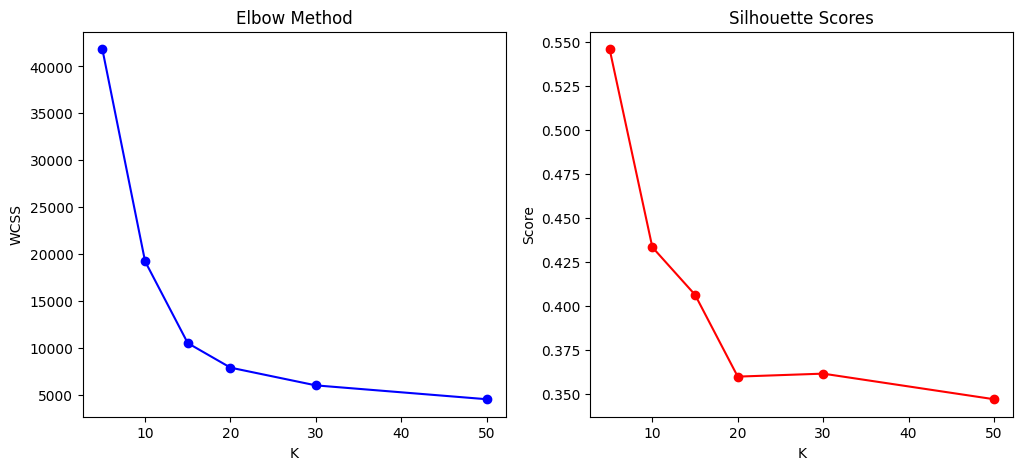

In [78]:
user_features_matrix = normalized_features
n_users = len(user_features_matrix)

class KMeanss:
    def __init__(self, k, max_iters=100, tol=1e-4, random_state=42):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels = []
        self.inertia_ = 0

    def _calculate_distance(self, p1, p2):
        return np.sqrt(np.sum((p1 - p2) ** 2))

    def fit(self, X):
        np.random.seed(self.random_state)
        n_samples = len(X)
        n_features = len(X[0])

        random_indices = np.random.choice(n_samples, self.k, replace=True)
        self.centroids = []
        for idx in random_indices:
            self.centroids.append(X[idx].copy())
        
        for iteration in range(self.max_iters):
            current_labels = []
            
            for i in range(n_samples):
                point = X[i]
                min_dist = float('inf')
                closest_centroid_idx = -1
                
                for j in range(self.k):
                    centroid = self.centroids[j]
                    dist = self._calculate_distance(point, centroid)
                    
                    if dist < min_dist:
                        min_dist = dist
                        closest_centroid_idx = j
                
                current_labels.append(closest_centroid_idx)
            
            self.labels = current_labels

            new_centroids = []
            cluster_sums = [[0.0] * n_features for _ in range(self.k)]
            cluster_counts = [0] * self.k
            
            for i in range(n_samples):
                cluster_idx = self.labels[i]
                point = X[i]
                cluster_counts[cluster_idx] += 1
                for f in range(n_features):
                    cluster_sums[cluster_idx][f] += point[f]
            
            for j in range(self.k):
                count_in_cluster = cluster_counts[j]
                if count_in_cluster > 0:
                    new_centroid = []
                    for f in range(n_features):
                        new_centroid.append(cluster_sums[j][f] / count_in_cluster)
                    new_centroids.append(np.array(new_centroid))
                else:
                    new_centroids.append(self.centroids[j])
            
            total_shift = 0.0
            for j in range(self.k):
                dist = self._calculate_distance(self.centroids[j], new_centroids[j])
                total_shift += dist
            
            self.centroids = new_centroids
            
            if total_shift < self.tol:
                break
        
        inertia_sum = 0.0
        for i in range(n_samples):
            point = X[i]
            cluster_idx = self.labels[i]
            centroid = self.centroids[cluster_idx]
            dist = self._calculate_distance(point, centroid)
            inertia_sum += dist ** 2
            
        self.inertia_ = inertia_sum
        return self

def distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

def silhouette(X, labels, sample_size=1000):
    total_samples = len(X)
    
    # Randomly select indices
    if total_samples <= sample_size:
        indices = np.arange(total_samples)
    else:
        np.random.seed(42) 
        indices = np.random.choice(total_samples, sample_size, replace=False)
    
    X_sample = X[indices]
    labels_array = np.array(labels) 
    labels_sample = labels_array[indices]
    n_subset = len(X_sample)
    
    clusters = {}
    for idx, label in enumerate(labels_sample):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(idx)
        
    unique_labels = list(clusters.keys())
    if len(unique_labels) < 2:
        return 0.0
        
    total_s = 0.0
    
    for i in range(n_subset):
        point_i = X_sample[i]
        label_i = labels_sample[i]
        
        same_cluster_indices = clusters[label_i]
        
        if len(same_cluster_indices) == 1:
            continue 
            
        dist_sum_a = 0.0
        for idx in same_cluster_indices:
            if idx == i: continue
            dist_sum_a += distance(point_i, X_sample[idx])
            
        a_i = dist_sum_a / (len(same_cluster_indices) - 1)
        
        b_i = float('inf')
        
        for label_j in unique_labels:
            if label_j == label_i: continue
            
            other_indices = clusters.get(label_j, [])
            if not other_indices: continue

            dist_sum_b = 0.0
            for idx in other_indices:
                dist_sum_b += distance(point_i, X_sample[idx])
            
            avg_dist_b = dist_sum_b / len(other_indices)
            
            if avg_dist_b < b_i:
                b_i = avg_dist_b
        
        max_ab = max(a_i, b_i)
        if max_ab == 0:
            s_i = 0.0
        else:
            s_i = (b_i - a_i) / max_ab
            
        total_s += s_i

    return total_s / n_subset


K_values = [5, 10, 15, 20, 30, 50]
kmeans_models = {}
user_clusters = {} 

for k in K_values:
    print(f"Applying K-means with K={k}...")
    kmeans = KMeanss(k=k) 
    kmeans.fit(user_features_matrix)
    kmeans_models[k] = kmeans
    user_clusters[f'Cluster_K{k}'] = kmeans.labels
    centroids_array = np.array(kmeans.centroids)
    print(f"  > K={k} completed. Inertia: {kmeans.inertia_:.2f}")

cluster_assignments_df = pd.DataFrame(user_clusters, index=np.arange(n_users))

wcss_values = []
silhouette_scores = []

print(f"\n Clustering Results) ---")

for k in K_values:
    model = kmeans_models[k]
    labels = model.labels 
    
    wcss = model.inertia_
    wcss_values.append(wcss)
    
    sil_score = silhouette(user_features_matrix, labels, 1000)
    silhouette_scores.append(sil_score)
    
    print(f"K={k} and WCSS: {wcss:.2f} and Silhouette: {sil_score:.4f}")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_values, wcss_values, marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('K')
plt.ylabel('WCSS')

plt.subplot(1, 2, 2)
plt.plot(K_values, silhouette_scores, marker='o', linestyle='-', color='r')
plt.title(f'Silhouette Scores')
plt.xlabel('K')
plt.ylabel('Score')

plt.show()

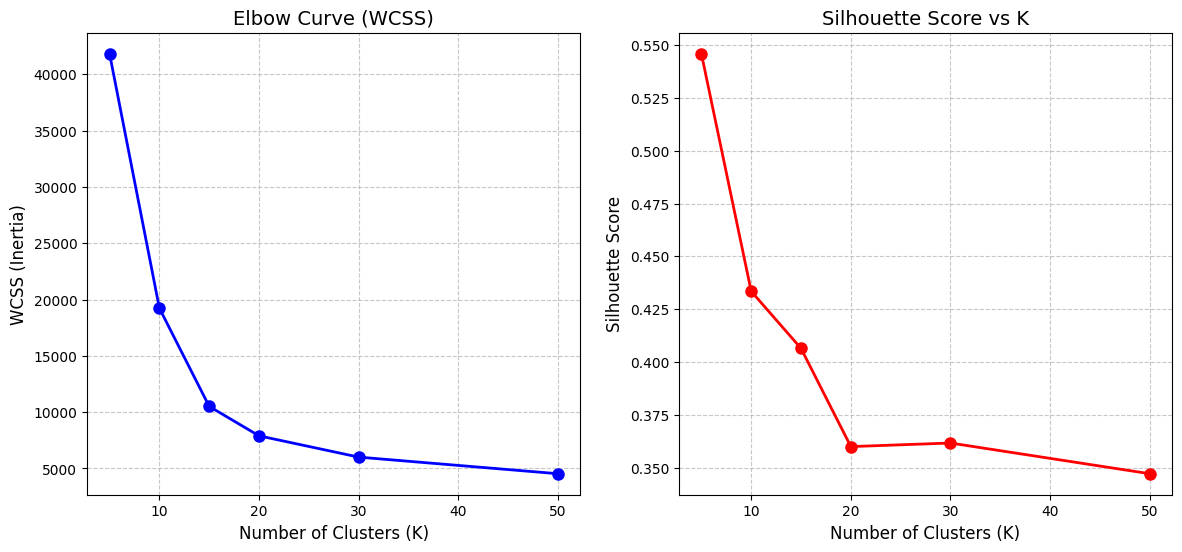

In [77]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(K_values, wcss_values, 'bo-', linewidth=2, markersize=8)
plt.title('Elbow Curve (WCSS)', fontsize=14)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('WCSS (Inertia)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(K_values, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.title('Silhouette Score vs K', fontsize=14)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

max_score = max(silhouette_scores)
max_k = K_values[silhouette_scores.index(max_score)]


Cluster Statistics):
         Avg_Common  Max_Common  Min_Common
Cluster                                    
9              4.23  421.000000         1.0
1              2.83  197.190002         1.0
13             2.48    6.360000         1.0
11             2.19  104.470001         1.0
5              2.09    9.230000         1.0
6              1.90   56.439999         1.0
4              1.80    9.300000         1.0
12             1.65   31.730000         1.0
0              1.56    6.650000         1.0
10             1.43   18.110001         1.0
8              1.39    6.970000         1.0
14             1.24    5.680000         1.0
3              1.24   11.440000         1.0
2              1.13    6.320000         1.0
7              1.06    3.960000         1.0
         Avg_Common  Max_Common  Min_Common
Cluster                                    
9          4.231578  421.000000         1.0
1          2.833822  197.185715         1.0
13         2.480224    6.361136         1.0
11        

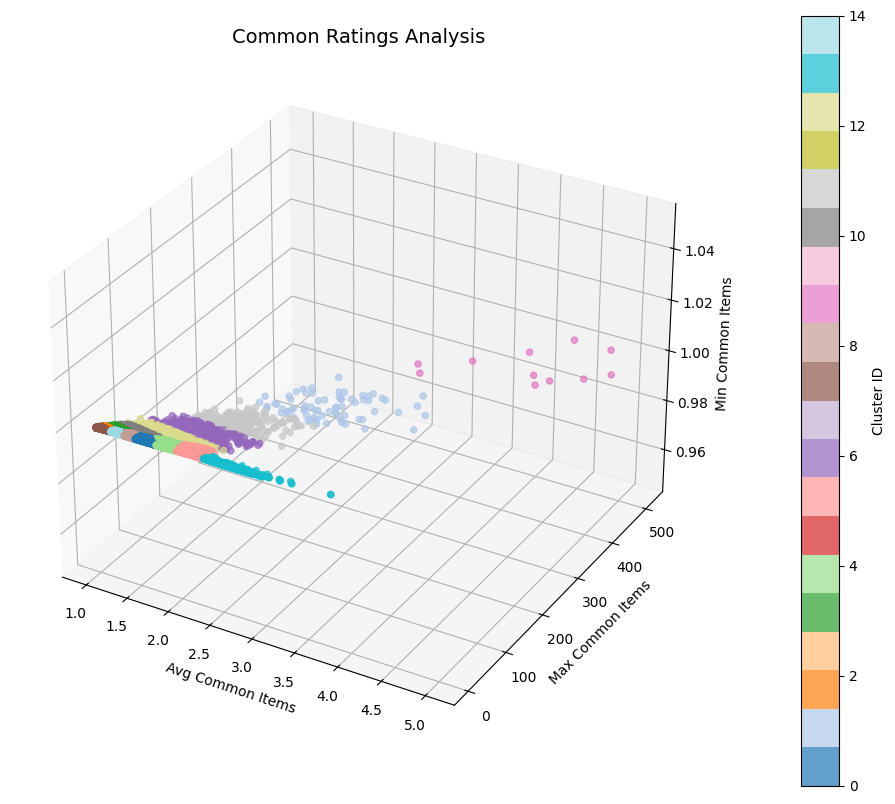

In [81]:
n_total = len(normalized_features)


X_sample = normalized_features
raw_sample = user_features

kmeans_opt = KMeanss(k=15)
kmeans_opt.fit(X_sample)
labels_opt = kmeans_opt.labels

df_analysis = pd.DataFrame(raw_sample, columns=['Avg_Common', 'Max_Common', 'Min_Common'])
df_analysis['Cluster'] = labels_opt

cluster_stats = df_analysis.groupby('Cluster').mean().sort_values('Avg_Common', ascending=False)

print("\nCluster Statistics):")
print(cluster_stats.round(2))

high_overlap = cluster_stats.head(5)
print(high_overlap)
low_overlap = cluster_stats.tail(5)
print(low_overlap)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_analysis['Avg_Common'], 
    df_analysis['Max_Common'], 
    df_analysis['Min_Common'],
    c=df_analysis['Cluster'], 
    cmap='tab20', 
    s=20,         
    alpha=0.7      
)

ax.set_title("Common Ratings Analysis", fontsize=14)
ax.set_xlabel('Avg Common Items')
ax.set_ylabel('Max Common Items')
ax.set_zlabel('Min Common Items')
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Cluster ID')

plt.show()

In [97]:
targets_users = data["targets_users"]
TARGET_USER_INDICES = [0,1,2]

BETA = 30 

centroids = np.array(kmeans_opt.centroids)
n_users_total = len(normalized_features)
all_labels = np.zeros(n_users_total, dtype=int)


for i in range(0, n_users_total, 1000):
    end = min(i + 1000, n_users_total)
    batch = normalized_features[i:end]

    dists = np.linalg.norm(batch[:, np.newaxis] - centroids, axis=2)
    all_labels[i:end] = np.argmin(dists, axis=1)

def compute_similarity(target_idx, candidate_idx, R_matrix):
    u_vec = R_matrix[target_idx]
    v_vec = R_matrix[candidate_idx]
    

    intersection = u_vec.multiply(v_vec)
    common_indices = intersection.indices
    
    num_common = len(common_indices)
    
    if num_common == 0:
        return 0.0, 0
    

    r_u = np.array([u_vec[0, col] for col in common_indices])
    r_v = np.array([v_vec[0, col] for col in common_indices])
    
    r_u_centered = r_u - r_u.mean()
    r_v_centered = r_v - r_v.mean()
    
    numerator = np.dot(r_u_centered, r_v_centered)
    denominator = np.linalg.norm(r_u_centered) * np.linalg.norm(r_v_centered)
    
    if denominator == 0:
        return 0.0, num_common
        
    return numerator / denominator, num_common

if not sp.isspmatrix_csr(R):
    R = R.tocsr()

final_recommendations = {}

for target_id in TARGET_USER_INDICES:
    cluster_id = all_labels[target_id]
    print(f"\nProcessing Target User U{target_id} (Cluster {cluster_id})...")
    
    cluster_indices = np.where(all_labels == cluster_id)[0]
    
    cluster_indices = cluster_indices[cluster_indices != target_id]
    
    print(f"  > Scanning {len(cluster_indices)} neighbors in Cluster {cluster_id}...")
    
    neighbors_list = []
    
    for neighbor_id in cluster_indices:
        sim, count = compute_similarity(target_id, neighbor_id, R)
        
        if sim > 0:
            df = min(1.0, count / BETA)
            
            ds = sim * df
            
            neighbors_list.append({
                'User_ID': neighbor_id,
                'Raw_Sim': sim,
                'Common': count,
                'DS': ds
            })
    
    if not neighbors_list:
        print("   No similar neighbors found.")
        continue
        
    df_neighbors = pd.DataFrame(neighbors_list)
    
    df_neighbors = df_neighbors.sort_values('DS', ascending=False)
    
    n_top = int(len(df_neighbors) * 0.20)
    if n_top < 1: n_top = 1 # Ensure at least 1 if list is short
    
    top_neighbors = df_neighbors.head(n_top)
    
    print(f"  Selected Top 20% ({len(top_neighbors)} users).")
    print(f"  Top Match: User {top_neighbors.iloc[0]['User_ID']} (DS: {top_neighbors.iloc[0]['DS']:.4f})")
    
    final_recommendations[f"U{target_id}"] = top_neighbors


Processing Target User U0 (Cluster 2)...
  > Scanning 21607 neighbors in Cluster 2...
   No similar neighbors found.

Processing Target User U1 (Cluster 14)...
  > Scanning 12875 neighbors in Cluster 14...
   No similar neighbors found.

Processing Target User U2 (Cluster 2)...
  > Scanning 21607 neighbors in Cluster 2...
   No similar neighbors found.


In [98]:
def predict_rating(target_u_name, neighbors_df, item_idx, R_matrix):
    if neighbors_df is None or neighbors_df.empty:
        return float('nan')
    neighbor_ids = neighbors_df['User_ID'].values.astype(int)
    similarities = neighbors_df['Discounted_Sim'].values

    neighbor_ratings = R_matrix[neighbor_ids, item_idx].toarray().flatten()

    mask = neighbor_ratings > 0
    if not np.any(mask):
        return float('nan')
        
    relevant_ratings = neighbor_ratings[mask]
    relevant_sims = similarities[mask]

    numerator = np.sum(relevant_sims * relevant_ratings)
    denominator = np.sum(relevant_sims)
    
    if denominator == 0:
        return 0.0
        
    return numerator / denominator

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



 DF Statistics
             mean       std  count
Cluster                           
8        0.312455  0.394275   9900
1        0.296981  0.443940   7365
11       0.226603  0.317579   9900
6        0.091357  0.145910   9900
7        0.063175  0.111711   9900
9        0.057769  0.117278   5005
0        0.050620  0.050276   9900
5        0.047808  0.051453   9900
13       0.044145  0.050283   9900
2        0.043027  0.056941   9900
12       0.031444  0.059903   9900
4        0.011505  0.032381   9900
10       0.008111  0.022366   9900
3        0.007589  0.020628   9900
14       0.001949  0.010234   9900


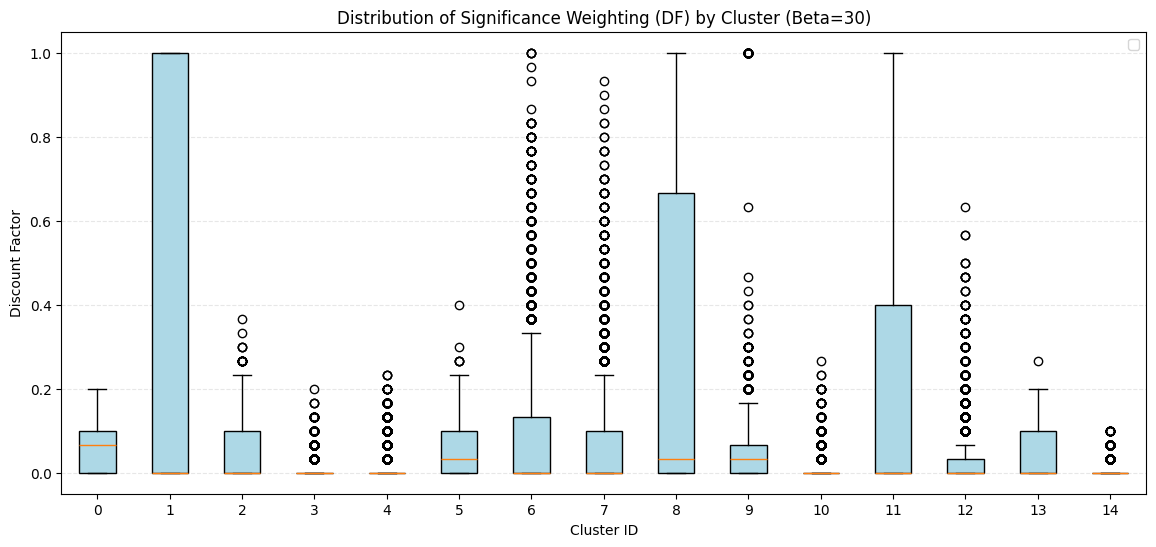

In [100]:
BETA = 30  
unique_clusters = np.unique(all_labels)
for k in unique_clusters:
    cluster_indices = np.where(all_labels == k)[0]
    if len(cluster_indices) > SAMPLES_PER_CLUSTER:
        np.random.seed(42) 
        sampled_indices = np.random.choice(cluster_indices, 100, replace=False)
    else:
        sampled_indices = cluster_indices
        
    if len(sampled_indices) < 2:
        continue 

    R_subset = R[sampled_indices]
    R_subset_bin = R_subset.copy()
    R_subset_bin.data[:] = 1
    
    intersection_matrix = R_subset_bin.dot(R_subset_bin.T)
    rows, cols = np.triu_indices(len(sampled_indices), k=1)
    common_counts = np.array(intersection_matrix[rows, cols]).flatten()
    
    dfs = np.minimum(common_counts, BETA) / BETA
    
    for val in dfs:
        df_analysis_list.append({
            'Cluster': k,
            'Discount_Factor': val
        })

df_sig_weight = pd.DataFrame(df_analysis_list)


if not df_sig_weight.empty:

    print("\n DF Statistics")
    stats = df_sig_weight.groupby('Cluster')['Discount_Factor'].agg(['mean', 'std', 'count'])
    print(stats.sort_values('mean', ascending=False))

    plt.figure(figsize=(14, 6))
    
    clusters_sorted = sorted(df_sig_weight['Cluster'].unique())
    plot_data = [df_sig_weight[df_sig_weight['Cluster'] == k]['Discount_Factor'].values for k in clusters_sorted]
    
    plt.boxplot(plot_data, labels=clusters_sorted, patch_artist=True, 
                boxprops=dict(facecolor="lightblue"))

    plt.title(f'Distribution of Significance Weighting (DF) by Cluster (Beta={BETA})')
    plt.ylabel('Discount Factor')
    plt.xlabel('Cluster ID')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.show()


Global Statistics:
Cold Start Users (<1 ratings): 0 (0.00%)
 Cluster  Pct_Cold_Start
       0             0.0
       1             0.0
       2             0.0
       3             0.0
       4             0.0
       5             0.0
       6             0.0
       7             0.0
       8             0.0
       9             0.0
      10             0.0
      11             0.0
      12             0.0
      13             0.0
      14             0.0
1. Extreme Sparse Cluster: Cluster 0
   -> 0.0% of users have almost no data.
   -> Strategy: Do NOT use Collaborative Filtering here. Use Content-Based or Popularity Baseline.

2. Extreme Dense Cluster: Cluster 0
   -> Only 0.0% cold start.
   -> Strategy: Standard User-Based CF is highly effective here.


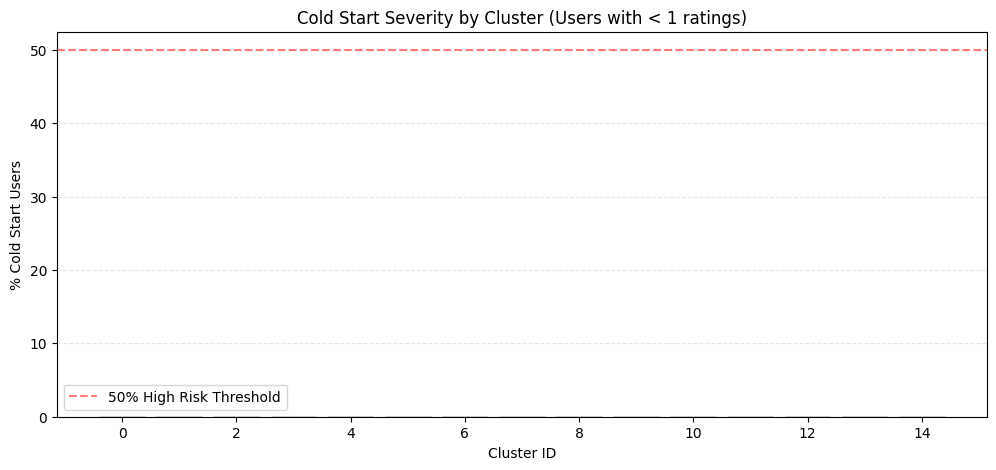

In [101]:
MIN_RATINGS_THRESHOLD = 1
user_rating_counts = np.array((R > 0).sum(axis=1)).flatten()

df_users = pd.DataFrame({
    'User_Index': range(len(user_rating_counts)),
    'Cluster': all_labels,
    'Rating_Count': user_rating_counts
})


cold_start_users = df_users[df_users['Rating_Count'] < MIN_RATINGS_THRESHOLD]
pct_cold_start = (len(cold_start_users) / len(df_users)) * 100

print(f"\nGlobal Statistics:")
print(f"Cold Start Users (<{MIN_RATINGS_THRESHOLD} ratings): {len(cold_start_users)} ({pct_cold_start:.2f}%)")

cluster_cold_stats = df_users.groupby('Cluster')['Rating_Count'].apply(
    lambda x: (x < MIN_RATINGS_THRESHOLD).mean() * 100
).reset_index(name='Pct_Cold_Start')
print(cluster_cold_stats.sort_values('Pct_Cold_Start', ascending=False).round(2).to_string(index=False))
worst_cluster = cluster_cold_stats.loc[cluster_cold_stats['Pct_Cold_Start'].idxmax()]
best_cluster = cluster_cold_stats.loc[cluster_cold_stats['Pct_Cold_Start'].idxmin()]
print(f"1. Extreme Sparse Cluster: Cluster {int(worst_cluster['Cluster'])}")
print(f"   -> {worst_cluster['Pct_Cold_Start']:.1f}% of users have almost no data.")
print("   -> Strategy: Do NOT use Collaborative Filtering here. Use Content-Based or Popularity Baseline.")

print(f"\n2. Extreme Dense Cluster: Cluster {int(best_cluster['Cluster'])}")
print(f"   -> Only {best_cluster['Pct_Cold_Start']:.1f}% cold start.")
print("   -> Strategy: Standard User-Based CF is highly effective here.")

plt.figure(figsize=(12, 5))
plt.bar(cluster_cold_stats['Cluster'], cluster_cold_stats['Pct_Cold_Start'], color='salmon', edgecolor='black')
plt.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% High Risk Threshold')
plt.xlabel('Cluster ID')
plt.ylabel('% Cold Start Users')
plt.title(f'Cold Start Severity by Cluster (Users with < {MIN_RATINGS_THRESHOLD} ratings)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()